In [5]:
import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences, of_lcs
import lightkurve_ext as lke
import lightkurve_ext_tess as lket
import tic_plot as tplt
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner

import asyncio_compat

import math
import time
from types import SimpleNamespace
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

import catalog_utils  # from ../src , for accessing various metadata about a TIC

import vetting_utils  # helpers specific for vetting

import dashboard_utils  # from ../src, for HD diagram

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, Markdown
display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
# notebook_url = "localhost:8889"

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
%%javascript
function isNBClassic() {
    // In Classic Notebook (Jupyter 6 or older), class notebook_app is in <body>
    return document.body.classList.contains('notebook_app');
}

// Add a sidebar UI
function addSideNav() {
    let ctr = document.getElementById('nav-ctr');
    if (ctr) { ctr.remove(); }
    const sections = [
        ['#input-tic', 'Enter TIC...'],
        ['#tic-metadata', ['TIC Metadata']],
        ['#lc-all', 'Lightcurves - all'],
        ['#lc-interactive', 'Interactive'],
        ['#lc-zoomed-in', 'Zoomed-in'],
        ['#marked-dips-deep', 'Marked deep dips'],  // often used to validate / refine the period
        ['#lc-fold', 'Folded LC'],
        ['#lc-period', "Add. Variability"],
        ['#lc-background-sso', 'Background'],
        ['#tpf_download', 'TPF Download'],
        ['#tpf_zoom_in', 'TPF Zoom in'],
        ['#reports', 'Reports'],
        ['#external_docs', "External Info"]
    ];
    // avoid and arrow functions and string with backslash n
    // they cause parsing failure with jupyter's display(HTML())
    function toASection(sec) {
      return `              <li><a href="${sec[0]}">${sec[1]}</a></li>`;
    }
    const sectionsHTML =
        sections.map(toASection).join(`
`);
    document.body.insertAdjacentHTML('beforeend', `
<div id="nav-ctr">
    <style>
        #nav-side {
            position: fixed; right: 2.5vh; top: 2.5em; z-index: 999;
            background-color: #feefc3; border: 1px solid lightgray; border-radius: 10%;
            padding: 0.25em 2ch 0.25em 0.5ch;
        }
        #nav-side.expand {
            padding: 0.25em 2ch;
        }
        #nav-side-expand {
            display: none;
        }
        .expand #nav-side-expand {
            display: block;
        }
        #nav-side-ctl-hideshow:before {
            content: "<<";
        }
        .expand #nav-side-ctl-hideshow:before {
            content: ">>";
        }

        #nav-side-expand ol {
            margin-left: 4ch;
            padding-left: 0;
        }
    </style>
    <div id="nav-side" class="expand"
         style="">
        <div id="nav-side-ctl-hideshow" style="float: right; cursor: pointer;" onclick="this.parentElement.classList.toggle('expand');"></div>
        <div id="nav-side-expand">
            <div>
                Jump to:
                <ol>
    ${sectionsHTML}
                </ol>
            </div>
            <div title="Control where the TIC Metadata is displayed, if available">
                TIC Metadata Output:<br>
                <button id="tic_metadata_run_ctl" accesskey="R" style="font-size: 80%">&nbsp;<u>R</u>un&nbsp;</button>&emsp;
                <button id="tic_metadata_float_fixed_toggle_2" accesskey="T" style="font-size: 80%;"
                        title="Toggle TIC Metadata as a floating table. Shortcut: Alt-T"
                        >Floa<u>T</u></button>
            </div>
        </div>
    </div>
</div>
`);

    // Assign keyboard shortcut to jump to the sections, Alt-1, 2, etc.
    Array.from(document.querySelectorAll('#nav-side-expand li > a'), (a, i) => {
        if (i <= 8) {
          a.accessKey = i + 1;
        }
        // special cases for frequently used TPF sections (they are in the 10s)
        if (a.getAttribute('href') == '#tpf_download') {
            a.accessKey = "A";
            a.title = "Shortcut: Alt-A";
        }
        if (a.getAttribute('href') == '#tpf_zoom_in') {
            a.accessKey = "B";
            a.title = "Shortcut: Alt-B";
        }
    });

    // single-click an anchor to enter the input area.
    // (User still need to press enter so that the cursor is in the cell)
    document.getElementById('nav-side-expand').onclick = function(evt) {
        if (evt.target.tagName != 'A') { return; }
        const anchor = evt.target.getAttribute('href').replace(/^#/, '');
        let cell = document.querySelector(`a[name="${anchor}"]`).parentElement.parentElement.parentElement.nextElementSibling.querySelector('.input_area'); // for Jupyter 6
        if (!cell) {
            cell = document.querySelector(`a[name="${anchor}"]`).parentElement.parentElement.parentElement.parentElement.nextElementSibling.querySelector('.jp-InputArea .jp-InputArea-editor .cm-editor .cm-content'); // Jupyter 7+
        }
        if (cell) {
            cell.scrollIntoView();
            cell.focus();
            cell.click();
        } else {
            console.warn(`Jump to ${anchor} failed. Cannot find the expected input area.`);
        }
        evt.preventDefault();
    };

    // douuble-click an anchor to jump to the output
    document.getElementById('nav-side-expand').ondblclick = function(evt) {
        if (evt.target.tagName != 'A') { return; }
        const anchor = evt.target.getAttribute('href').replace(/^#/, '');
        let cell = document.querySelector(`a[name="${anchor}"]`).parentElement.parentElement.parentElement.nextElementSibling.querySelector('.output');  // Jupyter 6
        if (!cell) {
            cell = document.querySelector(`a[name="${anchor}"]`).parentElement.parentElement.parentElement.parentElement.nextElementSibling.querySelector('.jp-Cell-outputArea');  // Jupyter 7
        }
        if (cell) {
            cell.scrollIntoView();
        } else {
            console.warn(`Jump to ${anchor} failed. Cannot find the expected output area.`);
        }
        evt.preventDefault();
    };


    // Run TIC Metadata cell
    function runTicMetadataCell() {
        if (isNBClassic()) {
            const ticMetaCellCtr = document.getElementById('TIC-Metadata').parentElement.parentElement.parentElement.nextElementSibling;
            ticMetaCellCtr.querySelector('.run_this_cell').click();
            ticMetaCellCtr.scrollIntoView();
        } else { // Jupyter 7
            const ticMetaCellCtr = document.getElementById('TIC-Metadata').parentElement.parentElement.parentElement.parentElement.nextElementSibling;
            // OPEN: In Jupyter 7, there is no equivalent of 'run_this_cell.click()
            // so I only scroll to the container and select it for now.
            // emulating Ctrl-Enter (to run the cell) does not work
            ticMetaCellCtr.scrollIntoView();
            ticMetaCellCtr.querySelector('.jp-InputArea-editor .cm-editor .cm-content').focus();
            /// const keyEvt = new KeyboardEvent("keypress", { "code": "Enter", "ctrlKey": true,});
            /// ticMetaCellCtr.querySelector('.jp-InputArea-editor .cm-editor .cm-content').dispatchEvent(keyEvt);
        }
    }

    document.getElementById('tic_metadata_run_ctl').onclick = runTicMetadataCell;

    // Making TIC Metadata output as a floating box
    // In Jupyter 7,  simply styling the div#tic_metadata_ctr as fixed is insufficient
    // (it's fixed with respect with some ancestor,  rather than the screen)
    // So it's reimplemented as copying the HTML to a dedicated fixed container
    // to create the illustion of a floating box.
    //
    function initTicMetaDataFixedStyle() {
      const styleCtr = document.getElementById('tic_metadata_fixed_style');
      if (styleCtr) {
        styleCtr.remove();
      }
      document.head.insertAdjacentHTML('beforeend', `<style id="tic_metadata_fixed_style">
    #tic_metadata_fixed_ctr {
        position: fixed;
        bottom: 12px;
        right: 36px;
        z-index: 990;  /* below the #nav-ctr */
        background-color: rgba(255, 255, 0, 0.3);
        padding: 6px;
        max-height: 75vh;  /* ensure for TIC with large number of TCEs, the floating box won't fill up too much vetical space */
        overflow-y: scroll;
        max-width: 50vw;  /* ensure the floating box won't fill up too much horizontal space */
        overflow-x: scroll;
    }
    #tic_metadata_fixed_ctr:hover { /* on hover, make it stand out more by decreasing transparency */
        background-color: rgba(255, 255, 127, 0.9);
    }
    </style>`);
    }

    function copyTICMetaDataToFixed() {
      const srcCtr = document.getElementById("tic_metadata_ctr");
      if (!srcCtr) {
        console.debug('copyTICMetaDataToFixed(): no source TIC Metadata. No-Op.');
        return false;
      }

      let destCtr = document.getElementById("tic_metadata_fixed_ctr");
      if (destCtr) {
        destCtr.remove();
      }
      // the css classes are for emulating Jupyter's styling for tables
      // Jupyter 7: jp-OutputArea-output jp-RenderedHTMLCommon jp-RenderedHTML
      // Jupyter 6: rendered_html
      document.body.insertAdjacentHTML('beforeend', `
      <div id="tic_metadata_fixed_ctr">
          <div id="tic_metadata_fixed_out" class="jp-OutputArea-output jp-RenderedHTMLCommon jp-RenderedHTML rendered_html"></div>
      </div>`);
      destCtr = document.getElementById("tic_metadata_fixed_out");

      destCtr.innerHTML = srcCtr.innerHTML;
      return true;
    }

    function initTicMetaDataOutputUiControls() {
        initTicMetaDataFixedStyle();
        // implement the hide/show button
        document.getElementById("tic_metadata_float_fixed_toggle_2").onclick = function(evt) {
            // TODO: to see if I can avoid removing it
            if (document.getElementById("tic_metadata_fixed_ctr")) {
                // case it's a floating box,  hide it
                // for now, it's done by removing it.
                document.getElementById("tic_metadata_fixed_ctr").remove();

                document.getElementById("tic_metadata_float_fixed_toggle_2").innerHTML = "Floa<u>T</u>";
            } else {
                // case no floating box,  show it
                const success = copyTICMetaDataToFixed()
                if (success) {
                    document.getElementById("tic_metadata_float_fixed_toggle_2").innerHTML = "Defaul<u>T</u>";
                }
            }
        };
    }
    initTicMetaDataOutputUiControls(); // init the button
} // function addSideNav()
addSideNav();


<IPython.core.display.Javascript object>

## Enter TIC, sector, subject
<a name="input-tic">

In [6]:
# lightkurve config
lk_download_dir = "data"
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 7 * 86400  # 0


# Run All Above and this cell to start
#
# TIC   : the TIC to be vetted
# sector: the sector that the notebook would use by default as the focus,
#         the lightcurves from all other sectors would be downloaded as well.
#         TPF of the given sector will be downloaded
# subject: an example subject on Planet Hunters TESS for the TIC, usually from the sector above.

# FILL-IN:
tic_sec_subj_str = "8153514	21	41037854"  # tab-separated input  from spreadsheet / dataframes output, e.g.,  288100746, 37, 62817178
tic, sector, subject =  [int(s) for s in tic_sec_subj_str.split("\t")[:3]]

max_num_sectors_to_download = None  #  None to download all sectors. Otherwise set it to a number to cap it, with the supplied sector as the centor of the slice to donwload
to_download_tpf_async = True
override_sector_with_first_sector = True
to_show_tic_meta = True


# def limit_sr_to_download(sr):
#     # used to limit data from cycle 1 - 3, but for vetting purpose, we use full data set
#     # sr = lk.SearchResult(sr.table[sr.table["sequence_number"] <= 39])
#     if max_num_sectors_to_download is None:
#             return sr
#     return lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)


# customized sector limiting
def limit_sr_to_download(sr):
    tab = sr.table
#     # for now we skip the few long-cadence sectors in 60 range so that I operate on the same dataset
#     tab = tab[tab["sequence_number"] <= 39]
    return lk.SearchResult(tab)


try:
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic,
                                                                                download_filter_func=limit_sr_to_download, download_dir=lk_download_dir,
                                                                                author_priority=["SPOC", "TESS-SPOC", "QLP"],
                                                                               )
    lcf_coll_original = lcf_coll  # retain a reference to the downloaded collection in case I modify it later
finally:
    tplt.beep()  # a beep to remind the users that the data has been downloaded

if override_sector_with_first_sector:
    # overide and use the first sector with 2 minute cadence data
    # Reason: if the TIC has TCEs, the epoch is generally from the first 2 minute cadence sector.
    sector_original = sector
    sector_first_short_cadence = sr[sr.exptime == 120 * u.s].table[0]["sequence_number"]
    if sector_first_short_cadence != sector_original:
        sector = sector_first_short_cadence
        print(f"INFO sector is overridden to be {sector} , the first short cadence sector.")

# Start downloading TPF asycnhronously while the user inspects the lightcurve
# Users can jump to "TPF Download" section to access the result
tpf_task = None
if to_download_tpf_async:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir=lk_download_dir)


metadata_html_task = None  # load TCEs asycnhronously  while the user inspects the lightcurve
if to_show_tic_meta:
    metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir=lk_download_dir)


lc = of_sector(lcf_coll, sector)
lket.display_crowdsap(lc)

4 rows filtered


#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 21,2020,SPOC,120,8153514,0.0,N/A
1,TESS Sector 48,2022,SPOC,120,8153514,0.0,G04171


TIC 8153514 	, all available sectors: 21, 48
downloaded #sectors: 2 ; 21, 48
   sector 48: 	camera = 1 ; ccd = 1


In [ ]:
# for triage MAST query issues
# _sr  = lk.search_lightcurve(f"TIC{tic}", mission="TESS")
#
# when needed, run this cell to download all sectors from primary mission or specific sectors
# lcf_coll = lk.SearchResult(sr.table[np.in1d(sr.table["sequence_number"], [1, 11, 12, 13])]).download_all(download_dir=lk_download_dir)
# tplt.beep()
# lcf_coll

## TIC Metadata
<a name="tic-metadata">

RS (in R☉),13.194
MS (in M☉),-1.000
Magnitude (TESS),9.10
T_eff (in K),4606.89013672


WARN Cannot plot TIC 8153514 on H-R diagram. Missing  Teff and/or Luminosity. Teff=4606.89, lum=nan


ID,objType,typeSrc,Tmag,Vmag,VmagFlag,rad,mass,lum,Teff,TeffFlag,GAIA,TWOMASS,disposition,duplicate_id,plx,PARflag,pmRA,pmDEC,PMflag,RA_orig,Dec_orig
str7,str4,str7,float64,float64,str7,float64,float64,float64,float64,str5,str18,str16,str1,str1,float64,str5,float64,float64,str5,float64,float64
8153514,STAR,tmgaia2,9.1003,10.04,hipvmag,13.1937,nan,nan,4606.89,spect,753931687192476288,10214349+3631535,--,--,1.29886,gaia2,-22.44,-16.6966,gaia2,155.431051789863,36.5314323200532


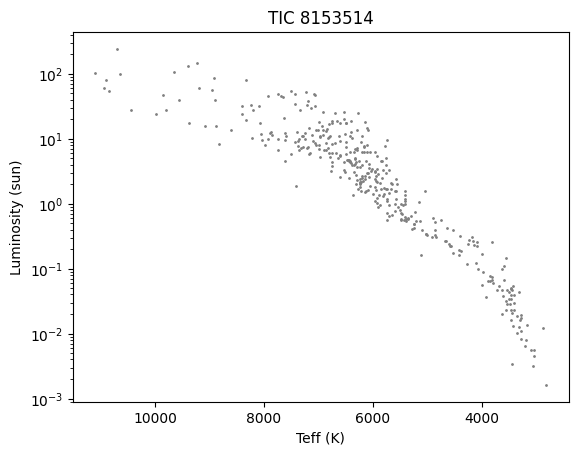

In [7]:
# reload(tplt)
# metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir="data")
display(HTML(await metadata_html_task))
ax = dashboard_utils.plot_tic_on_hr(tic,
                                    teff=None, lum=None,  # optionally specify them to override data from TIC
                                   );

# show info from TIC directly, could optionally be used to show multiple ones, e.g., to triage duplicates, splits, etc.
tics = [tic]
tic_rs = lket.catalog_info_of_tics(tics)
display(HTML("""<br>TIC Catalog parameters. Column Descriptions in:
<a href="https://outerspace.stsci.edu/display/TESS/TIC+v8.2+and+CTL+v8.xx+Data+Release+Notes" target="_tic_columns_doc">Data Release Notes</a> |
<a href="https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=IV/39" target="_tic_vizier" title="Vizier seems to have more complete information about various flag values.">Vizier table</a>
"""))
display(
    tic_rs['ID',
           'objType', 'typeSrc',
           'Tmag',
           'Vmag',
           'VmagFlag',  # source of Vmag
           'rad', 'mass', 'lum',
           'Teff', 'TeffFlag',
           'GAIA', 'TWOMASS', 'disposition', 'duplicate_id',
           'plx', 'PARflag',
           'pmRA', 'pmDEC', 'PMflag',
           'RA_orig', 'Dec_orig',
          ]
)

## Variability from other catalogs
<a name="meta_other_catalogs"></a>

In [32]:
# Used for display here, but also for later, e.g., in reports
# reload(vetting_utils)
all_meta = catalog_utils.get_all_meta_of_tic(tic)

vetting_utils.display_all_meta_highlights(all_meta)

### SIMBAD&emsp;[live](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=BD%2B37++2070) , [references](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=BD%2B37++2070#lab_bib)

MAIN_ID,FLUX_V,OTYPES,V__vartyp
BD+37 2070,10.160000,RG*|*|IR,nan


### VSX

Name,Type


### ASAS-SN

ASASSN-V,Vmag,Type,Prob,Per


### TESS EB&emsp;[live](http://tessebs.villanova.edu/0008153514)

TIC,Per,Epochp,Epochs-pf,Morph,Sectors


### Gaia DR3 / DR3 Variable&emsp;[live](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ6553efc5ee22b&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=%2BI%2F355%2Fgaiadr3%2BI%2F355%2Fparamp&%2F%2Fc=07%3A43%3A56.28+-60%3A23%3A47&%2F%2Ftables=I%2F355%2Fgaiadr3&%2F%2Ftables=I%2F355%2Fparamp&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&-out.add=_r&%2F%2Foutaddvalue=default&-sort=_r&-order=I&-oc.form=sexa&-nav=cat%3AI%2F355%26tab%3A%7BI%2F355%2Fgaiadr3%7D%26tab%3A%7BI%2F355%2Fparamp%7D%26key%3Asource%3D%2BI%2F355%2Fgaiadr3%2BI%2F355%2Fparamp%26key%3Ac%3D07%3A43%3A56.28+-60%3A23%3A47%26pos%3A07%3A43%3A56.28+-60%3A23%3A47%28+15+arcsec%29%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=+15&-c.u=arcsec&-c.geom=r&-source=&-out.src=I%2F355%2Fgaiadr3%2CI%2F355%2Fparamp&-x.rs=10&-source=I%2F355%2Fgaiadr3+I%2F355%2Fparamp&-out.orig=standard&-out=RA_ICRS&-out=DE_ICRS&-out=Source&Source=753931687192476288&-out=Plx&-out=PM&-out=pmRA&-out=pmDE&-out=sepsi&-out=RUWE&-out=Dup&-out=Gmag&-out=BPmag&-out=RPmag&-out=BP-RP&-out=RV&-out=e_RV&-out=Vbroad&-out=GRVSmag&-out=VarFlag&-out=NSS&-out=XPcont&-out=XPsamp&-out=RVS&-out=EpochPh&-out=EpochRV&-out=MCMCGSP&-out=MCMCMSC&-out=Teff&-out=logg&-out=%5BFe%2FH%5D&-out=Dist&-out=A0&-out=HIP&-out=PS1&-out=SDSS13&-out=SKYM2&-out=TYC2&-out=URAT1&-out=AllWISE&-out=APASS9&-out=GSC23&-out=RAVE5&-out=2MASS&-out=RAVE6&-out=RAJ2000&-out=DEJ2000&-out=Pstar&-out=PWD&-out=Pbin&-out=ABP&-out=ARP&-out=GMAG&-out=Rad&-out=SpType-ELS&-out=Rad-Flame&-out=Lum-Flame&-out=Mass-Flame&-out=Age-Flame&-out=Flags-Flame&-out=Evol&-out=z-Flame&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)

,Source,RAJ2000,DEJ2000,Gmag,BP-RP,Teff,RUWE,sepsi,e_RV,Dup,Class,ClassSc
165,753931687192476288,155.431173,36.531504,9.744366,1.242173,NaN,1.734,49.064,2.52,0,NaN,NaN


NSS indicators: `RUWE: 1.734, sepsi: 49.064, e_RV: 2.52 km/s .`


### Misc. EB Catalogs from TESS observations
- [TESS OBA-type eclipsing binaries (IJspeert+, 2021)](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ655788c4386ef3&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=J%2FA%2BA%2F652%2FA120%2Feb-cat&%2F%2Ftables=J%2FA%2BA%2F652%2FA120%2Feb-cat&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=J%2FA%2BA%2F652%2FA120%2Feb-cat&-nav=cat%3AJ%2FA%2BA%2F652%2FA120%26tab%3A%7BJ%2FA%2BA%2F652%2FA120%2Feb-cat%7D%26key%3Asource%3DJ%2FA%2BA%2F652%2FA120%2Feb-cat%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-source=J%2FA%2BA%2F652%2FA120%2Feb-cat&-out=TIC&TIC=8153514&-out=RAJ2000&-out=DEJ2000&-out=Jmag&-out=Hmag&-out=Kmag&-out=Gmag&-out=Tmag&-out=LumClass&-out=BPmag&-out=RPmag&-out=WDFlag&-out=SimbadOtype&-out=SimbadSptype&-out=tsupcon&-out=eclPer&-out=eclScore&-out=DepthP&-out=DepthS&-out=WidthP&-out=WidthS&-out=tsupconT&-out=eclPerT&-out=FlagS&-out=FlagVar&-out=FlagCont&-out=FlagHeart&-out=dupl-group&-out=Simbad&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)
- [TESS Close Binaries in the southern hemisphere (Justesen+, 2021)](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ655789fb3aa4f3&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=J%2FApJ%2F912%2F123&%2F%2Ftables=J%2FApJ%2F912%2F123%2Ftable2&%2F%2Ftables=J%2FApJ%2F912%2F123%2Ftable3&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=J%2FApJ%2F912%2F123%2Ftable2%2CJ%2FApJ%2F912%2F123%2Ftable3&-nav=cat%3AJ%2FApJ%2F912%2F123%26tab%3A%7BJ%2FApJ%2F912%2F123%2Ftable2%7D%26tab%3A%7BJ%2FApJ%2F912%2F123%2Ftable3%7D%26key%3Asource%3DJ%2FApJ%2F912%2F123%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-source=J%2FApJ%2F912%2F123%2Ftable2+J%2FApJ%2F912%2F123%2Ftable3&-out=TIC&TIC=8153514&-out=Per&-out=t1&-out=t2&-out=ecosw&-out=d1&-out=d2&-out=Tmag&-out=Simbad&-out=_RA&-out=_DE&-out=rp&-out=a%2FR1&-out=esinw&-out=inc&-out=fp&-out=Teff1&-out=Teff2&-out=f_Teff&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)
- [δ Scuti Pulsators in EBs from TESS (Chen+, 2022)](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65578b153bda7e&-to=-4b&-from=-2&-this=-4&%2F%2Fsource=J%2FApJS%2F263%2F34&%2F%2Ftables=J%2FApJS%2F263%2F34%2Ftable1&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=J%2FApJS%2F263%2F34%2Ftable1&-nav=cat%3AJ%2FApJS%2F263%2F34%26tab%3A%7BJ%2FApJS%2F263%2F34%2Ftable1%7D%26key%3Asource%3DJ%2FApJS%2F263%2F34%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-source=J%2FApJS%2F263%2F34%2Ftable1&-out=TIC&TIC=8153514&-out=RAJ2000&-out=DEJ2000&-out=Tmag&-out=Porb&-out=Pdom&-out=TeffT&-out=loggT&-out=TeffG&-out=loggG&-out=Lbol&-out=EType&-out=PType&-out=NewPB&-out=Ref&-out=S22&-out=P22&-out=Simbad&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)
- [Pulsating Stars in EA-type eclipsing binaries observed by TESS (Shi+, 2022)](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65578bc23c6846&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=J%2FApJS%2F259%2F50%2Ftable1&%2F%2Ftables=J%2FApJS%2F259%2F50%2Ftable1&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=J%2FApJS%2F259%2F50%2Ftable1&-nav=cat%3AJ%2FApJS%2F259%2F50%26tab%3A%7BJ%2FApJS%2F259%2F50%2Ftable1%7D%26key%3Asource%3DJ%2FApJS%2F259%2F50%2Ftable1%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-source=J%2FApJS%2F259%2F50%2Ftable1&-out=TIC&TIC=8153514&-out=f_TIC&-out=Name&-out=RAJ2000&-out=DEJ2000&-out=Cons&-out=Per&-out=u_Per&-out=mag1&-out=mag2&-out=n_mag&-out=l_mag&-out=Filter&-out=Sep&-out=Simbad&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)
- [Multiply eclipsing candidates from TESS satellite (Zasche+, 2022)](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-ref=VIZ65578c393cd155&-to=-4b&-from=-3&-this=-4&%2F%2Fsource=J%2FA%2BA%2F664%2FA96&%2F%2Ftables=J%2FA%2BA%2F664%2FA96%2Ftable1&%2F%2Ftables=J%2FA%2BA%2F664%2FA96%2Ftablea1&-out.max=50&%2F%2FCDSportal=http%3A%2F%2Fcdsportal.u-strasbg.fr%2FStoreVizierData.html&-out.form=HTML+Table&%2F%2Foutaddvalue=default&-order=I&-oc.form=sexa&-out.src=J%2FA%2BA%2F664%2FA96%2Ftable1%2CJ%2FA%2BA%2F664%2FA96%2Ftablea1&-nav=cat%3AJ%2FA%2BA%2F664%2FA96%26tab%3A%7BJ%2FA%2BA%2F664%2FA96%2Ftable1%7D%26tab%3A%7BJ%2FA%2BA%2F664%2FA96%2Ftablea1%7D%26key%3Asource%3DJ%2FA%2BA%2F664%2FA96%26HTTPPRM%3A&-c=&-c.eq=J2000&-c.r=++2&-c.u=arcmin&-c.geom=r&-source=&-x.rs=10&-source=J%2FA%2BA%2F664%2FA96%2Ftable1+J%2FA%2BA%2F664%2FA96%2Ftablea1&-out=RAJ2000&-out=DEJ2000&-out=VSX&-out=n_VSX&-out=TIC&TIC=8153514&-out=magmax&-out=JD0A&-out=Per&-out=DP&-out=n_DP&-out=DS&-out=n_DS&-out=JD0O&-out=Com&-out=SimbadName&-out=EBtype&-out=PerA&-out=DPA&-out=DSA&-out=PerB&-out=DPB&-out=DSB&-meta.ucd=2&-meta=1&-meta.foot=1&-usenav=1&-bmark=GET)


## Lightcurves - all sectors
<a name="lc-all">

Obs span: 765.5513416315473  ; num. of days: 56
Sectors 21, 48:


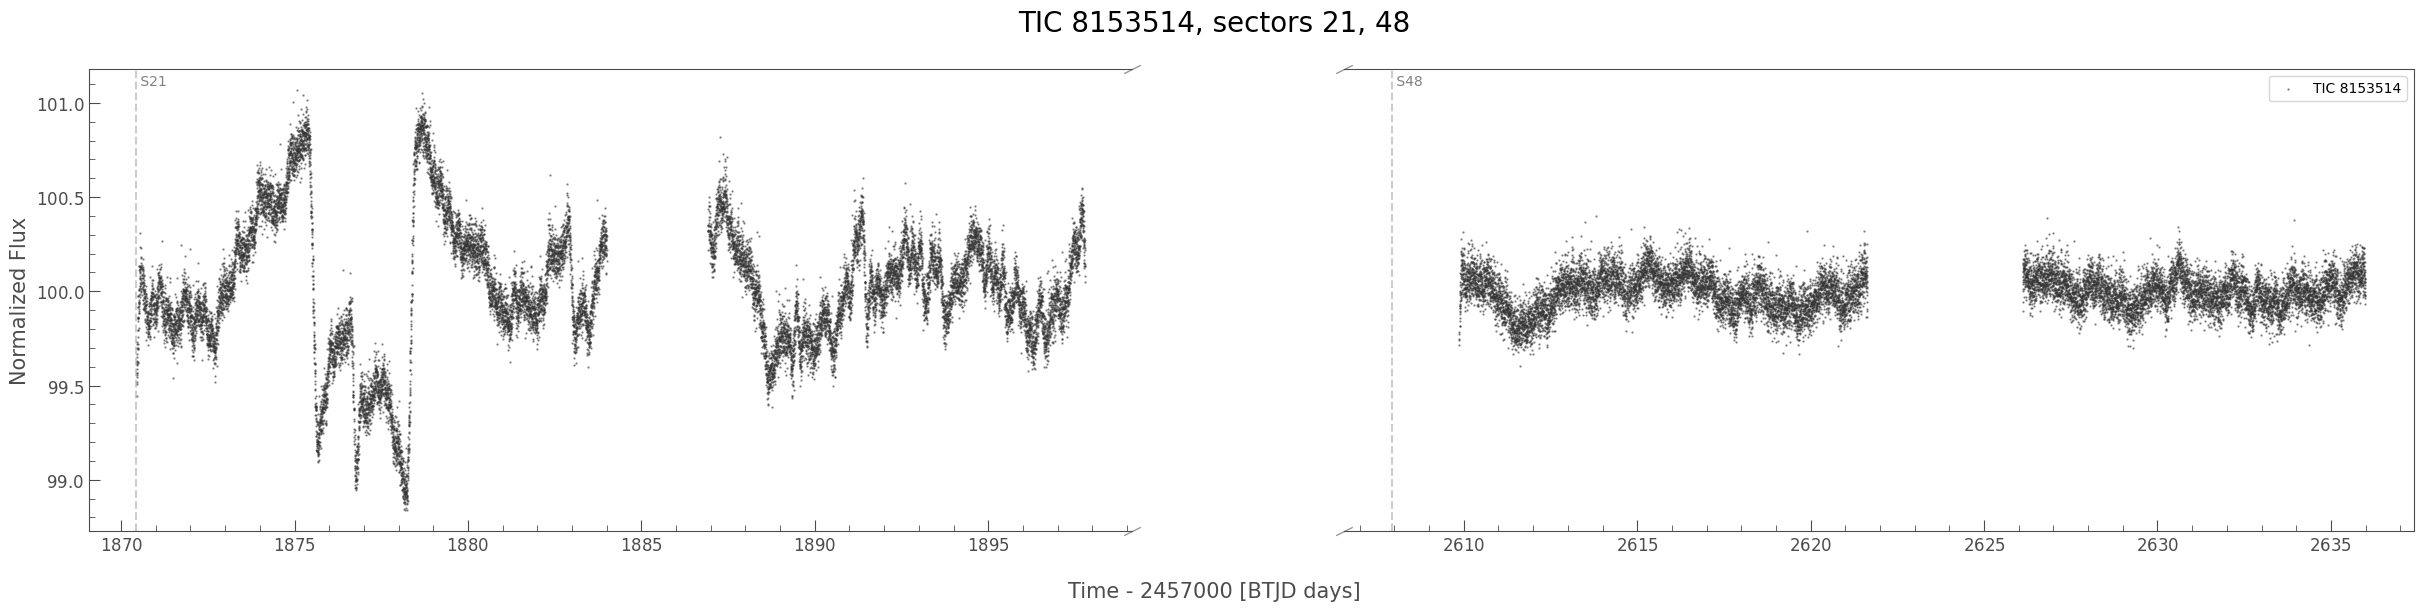

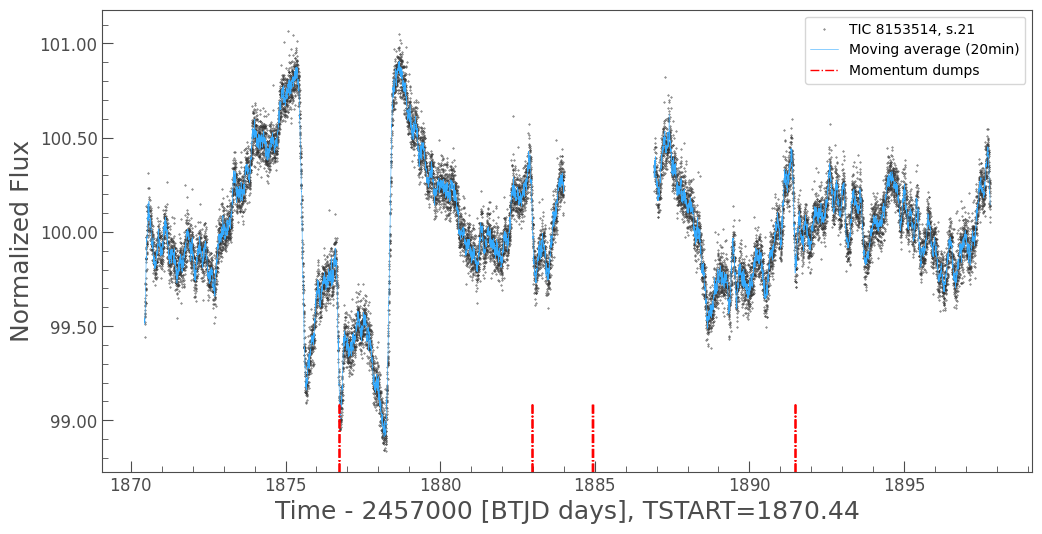

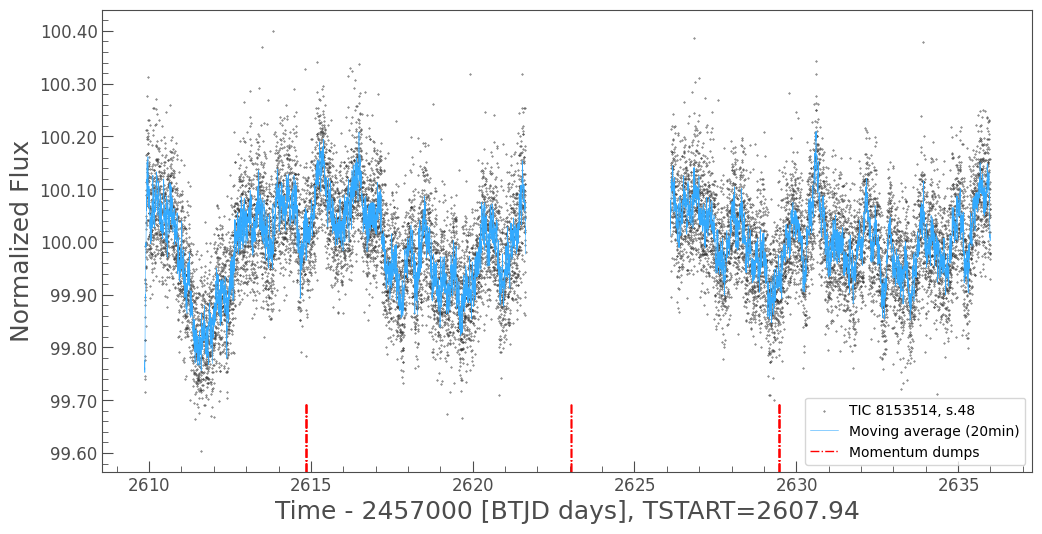

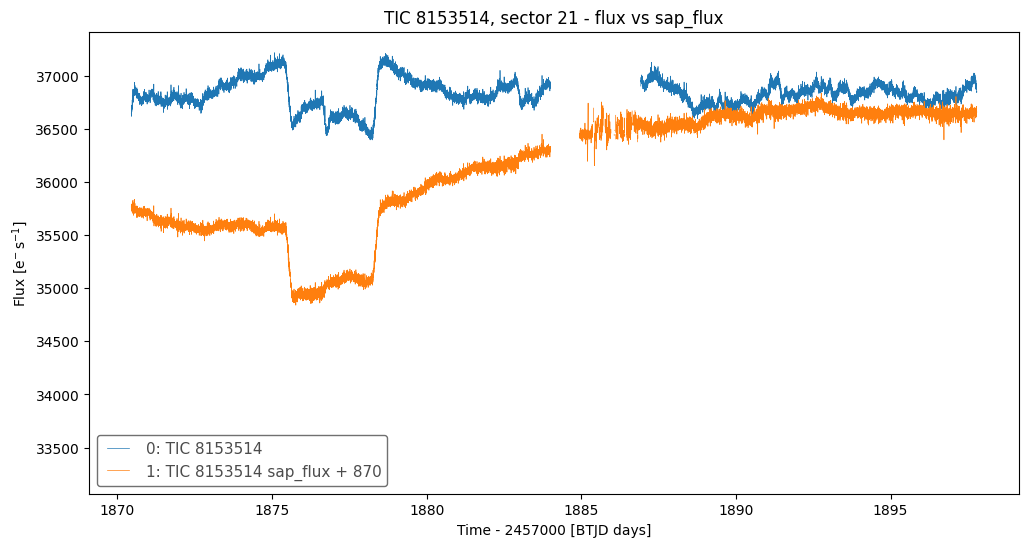

In [42]:
# Use lcf_coll_original rather than lcf_coll,
# in case lcf_coll is modified by the manual exclude section
# (here we want to plot the downloaded data as-is)

obs_span, obs_actual_days = lke.get_obs_date_range(lcf_coll_original)
print(f"Obs span: {obs_span}  ; num. of days: {obs_actual_days}")


# ---

lc = lke.stitch(
    lcf_coll_original,
    corrector_func=lambda lc: (
        lc
#         .select_flux("sap_flux")
#         .remove_outliers(sigma=7)
        .normalize(unit="percent")
    ),
    ignore_incompatible_column_warning=True,
).normalize(unit="percent")

print(f"Sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}:")
axs = tplt.plot_skip_data_gap(lc, figsize=(30,6), s=2, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}", fontsize=20);
# [ax.set_ylim(99.8, None) for ax in axs];


# Zoom in to the first and the last known sectors

figsize=(12, 6)
if len(lcf_coll_original) >= 2:
    lcf_coll_first_last = lk.LightCurveCollection([lcf_coll_original[0], lcf_coll_original[-1], ])
else:
    lcf_coll_first_last = lk.LightCurveCollection([lcf_coll_original[0]])

axs = tplt.plot_all(
    lcf_coll_first_last,
    moving_avg_window='20min',
    ax_fn=lambda: tplt.lk_ax(figsize=figsize),
    use_relative_time=False,
    mark_quality_issues=False,
    mark_momentum_dumps=True,
    set_title=False,
)

# as a sanity check, in case PDCSAP_FLUX has some anomaly (e.g., remvoing a good dip)
ax_flux_cmp = tplt.plot_flux_sap_flux_comparison(of_sector(lcf_coll_original, sector), ax=plt.figure(figsize=figsize).gca(),
                                                 offset=None)

### Manual exclude problematic cadences, if any

In [ ]:
# display(HTML("The 2 small spikes are probably flares. So no exclusion is needed."))
# axs = tplt.plot_all(of_sectors(lcf_coll, 9, 13))
# axs[0].set_xlim(1546, 1550);
# axs[1].set_xlim(1659, 1663);

In [ ]:
to_mask_out_cadences = False

if to_mask_out_cadences:
    # a new collection that I'd modify
    lcf_coll = lk.LightCurveCollection(lcf_coll_original.data)
    # custom codes to mask out problematic cadences
    #
    # the flux in sector 9 QLP lc at the beginning of an orbit does not appear to be reliable
    # it seems background is not subtracted sufficiently
    idx = -1 # FILL IN
    lc = lcf_coll[idx]
    lc = lke.exclude_range(lc, )   # FILL IN
    lcf_coll[idx] = lc

    # plot all lightcurves again for visual validation
    axs = tplt.plot_skip_data_gap(
        lke.stitch(lcf_coll, corrector_func=tplt.normalize_percent, ignore_incompatible_column_warning=True),
        figsize=(30,6), s=2, alpha=0.5
        );


## Identify initial period with BLS

In [ ]:
run_bls = False

lc = lke.stitch(
    lcf_coll,
    corrector_func=lambda lc: lc.normalize(unit="percent"),
    ignore_incompatible_column_warning=True,
)

print("Total num. data points:", len(lc), f" ; time span:  {(lc.time.max() - lc.time.min()).value:.0f} d")

if run_bls:
    # data points for BLS run time
    # for a 18-sector LC (~half 30-min, ~half 2-min), with 163328 data points
    # - minimum_period=1, maximum_period=20, frequency_factor=1000:
    #   - run_time: 18.6s, period grid size: 19277
    # - minimum_period=1, maximum_period=20, frequency_factor=100:
    #   - run_time: 174s, period grid size: 192761
    #   - period: 1.995467302777175 , epoch=1326.8983504171797, duration=0.15
    result = lke_pg_runner.run_bls(lc, pg_kwargs=dict(
        minimum_period=1, maximum_period=20,
        frequency_factor=1000,
    ))
    print(f"BLS run time: {round(result.pg.elapsed_time / 1000, 1)}s")
    tplt.beep()  # a beep to remind the users it's done

#     lc.normalize().interact_bls(notebook_url=notebook_url)

## Magnitude Range / Amplitude

Sectors 21, 48:
Max/Min (normalized): 1.0106846 0.98839355
Max/Min (magnitude) : 9.08876 9.112975


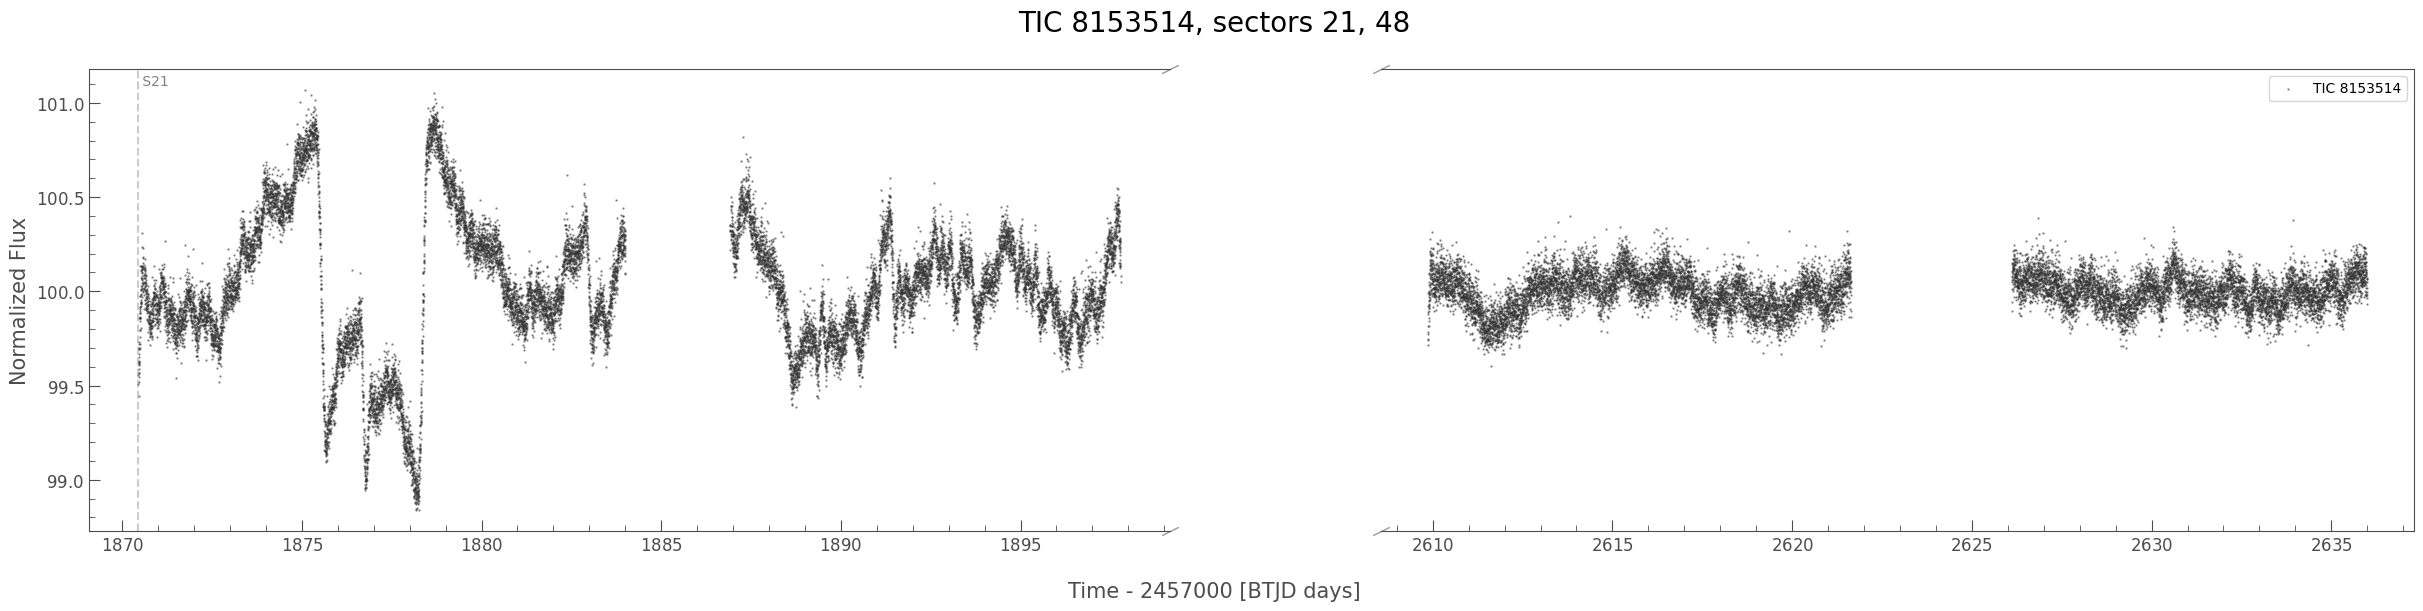

In [25]:
res = lket.calc_flux_range(lcf_coll)

# they'll be used in reports at the end
flux_range_pct = res.flux_range_pct
flux_range_mag = res.flux_range_mag

# report and visualzie the results
lc = res.lc_stitched
print(f"Sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}:")
print("Max/Min (normalized):", flux_range_pct[0], flux_range_pct[1])
print("Max/Min (magnitude) :", flux_range_mag[0], flux_range_mag[1])

axs = tplt.plot_skip_data_gap(lc, figsize=(30,6), s=2, alpha=0.5);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc.meta['SECTORS'])}", fontsize=20);

## Lightcurve - interactive
<a name="lc-interactive">

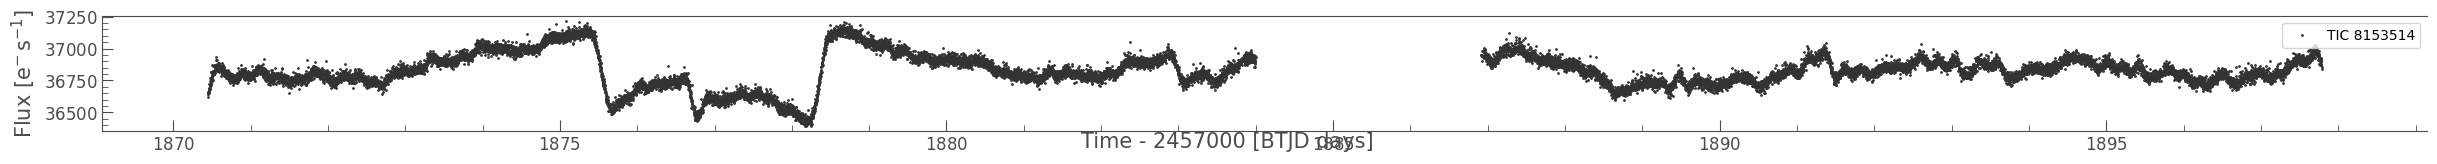

Output(layout=Layout(border='1px solid lightgray', padding='1em 0px'))

Output(layout=Layout(padding='1em'))

In [10]:
# interactively view a lightcurve
lcf = of_sector(lcf_coll, sector)
# lcf = lke.stitch(lcf_coll, corrector_func=lambda lc: lc.normalize(unit="percent"))

lket.display_crowdsap(lcf)
display(HTML(f"TSTART: {lcf.meta.get('TSTART')}"))  # To aid relative time conversion


# make zoom in to a specific dip eaiser
tplt.plot_skip_data_gap(lcf, figsize=(30, 1.5)); # a small overall view
tplt.plot_transit_interactive(lcf, figsize=(30, 10)
#                               ,flux_col='sap_flux'
                             );

### More Interactive plot
- this version is better for free-form exploration, and marking arbitrary times.

In [ ]:
lcf = lke.stitch(lcf_coll, corrector_func=lambda lc: lc.normalize(unit="percent"))

tplt.plot_skip_data_gap(lcf, figsize=(30, 1.5)); # a small overall view
result = tplt.interact(lcf, plot_width=1200, plot_height=640, show_line=False, notebook_url=notebook_url, ylim_func=lambda lc: (np.nanmin(lc.flux).value.item(), np.nanmax(lc.flux).value.item()))

In [ ]:
# print the times marked for later usage
[round(i['time'], 2) for i in result.mark_list]

## Lightcurve - zoomed in
<a name="lc-zoomed-in"></a>

- Eclipse specification is defined here in `transit_specs`

Transits, zoomed-in


label,epoch,duration_hr,period
str15,float64,float64,float64
single long dip,1876.95,75.0,999.0


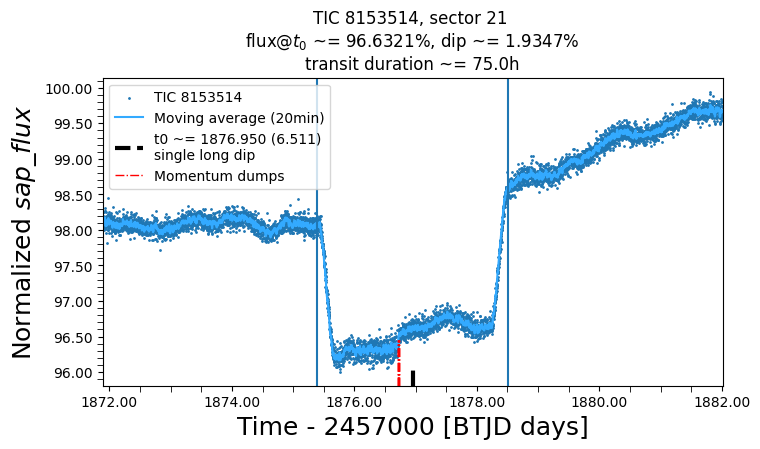

In [17]:
# Plots, zoomed-in around selected dips / transits

# transit_specs for calling plot_transits()
transit_specs = TransitTimeSpecList(
    dict(epoch=1876.95, duration_hr=75.0, period=999.0, label="single long dip",
         sector=21, steps_to_show=[0],
        ),
    defaults=dict(surround_time=7.0)
)



def custom_lc_tweak(lc):
    res = lc
    # res = res.remove_outliers(sigma=7)
    # res = res.bin(time_bin_size=20 * u.min)
    return res

figsize = (8, 4) # (16, 4)
axs = tplt.plot_transits(
                         lcf_coll # [of_sectors(lcf_coll, 27)[1], of_sectors(lcf_coll, 28)[1]]
                         , transit_specs
                         , flux_col = "sap_flux"
                         , ax_fn=lambda: plt.figure(figsize=figsize).gca()
                         , t0mark_ymax=0.05
#                          , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=7)
                         , lc_tweak_fn=custom_lc_tweak
                         , moving_avg_window='20min' # None # '30min' # '10min' # None, '20min' #  '30min'
#                          , set_title=False
                         , show_r_obj_estimate=False
                         , title_fontsize=12
                        )
# axs[0].set_ylim(None, 100.15)
print('Transits, zoomed-in');
display(transit_specs.to_table());

# The phase of Min II (the shallow dips)
if len(transit_specs) > 1 and transit_specs[0]['period'] < 999:  # 999 indicates no known period by convention
    min2_phase = ((transit_specs[1]['epoch'] - transit_specs[0]['epoch']) / transit_specs[0]['period']) % 1
    print("Min II phase in [-1.0, 1.0]:", min2_phase, "in days:", transit_specs[0]['period'] * min2_phase)
    if (min2_phase > 0.5):
        print("Min II phase in [-0.5, 0.5]:", min2_phase - 1, "in days:", transit_specs[0]['period'] * (min2_phase - 1))
        
display(HTML("<code>SAP_FLUX</code> might be more reliable in this case."));

#### Compare with identified eclipses with TESS EB results, if any

In [ ]:
if len(all_meta.tesseb) > 0:
    vetting_utils.display_no_index(all_meta.tesseb[["TIC", "Per", "Epochp", "Durationp-pf", "Dp-pf", "Epochs-pf", "Durations-pf", "Ds-pf"]])
    vetting_utils.display_no_index(all_meta.tesseb[["TIC", "Per", "Epochp", "Durationp-2g", "Dp-2g", "Epochs-2g", "Durations-2g", "Ds-2g"]])
else:
    print("No TESS EB entry.")

### Custom Crowding Correction

In [ ]:
# Crowding correction
# see https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowding.html

do_custom_crowding = False
lc = of_sector(lcf_coll, sector)
lc = lc.truncate(transit_specs[0]['epoch'] - transit_specs[0]['duration_hr'] / 24, transit_specs[0]['epoch']  + transit_specs[0]['duration_hr'] / 24)  # optional zoom in

crowdsap = lc.meta["CROWDSAP"]  # FILL-IN: override for cases that there are nearby stars not accounted in TIC, etc.
flfrcsap = lc.meta["FLFRCSAP"]

if do_custom_crowding:
    lc_sap = lc.select_flux("sap_flux")

    with plt.style.context(lk.MPLSTYLE):
        fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey=True);

    ax1 = lc_sap.normalize(unit="percent").scatter(ax=axs[0]);
    ax1.set_title(f"{lc.label} SAP_FLUX")
    ax2 = lc.normalize(unit="percent").scatter(ax=axs[1]);
    ax2.set_ylabel(None)
    ax2.set_title(f"{lc.label} PDCSAP_FLUX\nCROWDSAP: {round(lc.meta.get('CROWDSAP', -1), 2)}, FLFRCSAP: {round(lc.meta.get('FLFRCSAP', -1), 2)}");

    # create a crowding corrected LC based on SAP_FLUX, based on custom crowdsap, flfrcsap
    def correct_crowding(lc_sap, crowdsap, flfrcsap):
        median_flux = np.median(lc_sap.flux)
        excess_flux = (1 - crowdsap) * median_flux
        flux_removed = lc_sap.flux  - excess_flux  # note: a **constant** amount of flux is removed, so a dip would be proportionally deeper
        flux_corr = flux_removed / flfrcsap
        lc_corr = lk.LightCurve(time=lc_sap.time, flux=flux_corr)
        lc_corr.meta.update(lc_sap.meta)
        lc_corr.meta["CROWDSAP"] = crowdsap
        lc_corr.meta["FLFRCSAP"] = flfrcsap
        return lc_corr


    lc_corr = correct_crowding(lc_sap, crowdsap, flfrcsap)

    ax3 = lc_corr.normalize(unit="percent").scatter(ax=axs[2]);
    ax3.set_ylabel(None)
    ax3.set_title(f"{lc_corr.label}, custom crowding correction\nCROWDSAP: {round(lc_corr.meta.get('CROWDSAP', -1), 2)}, FLFRCSAP: {round(lc_corr.meta.get('FLFRCSAP', -1), 2)}");

    plt.tight_layout();
    plt.subplots_adjust(wspace=0.02);

## Lightcurves - eclipses marked
<a name="lc-transits">

<TessLightCurve LABEL="TIC 8153514" SECTOR=48 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux> is skipped - no matching transits.
[{'epoch': 1876.95, 'period': 999.0, 'duration_hr': 75.0, 'sector': 21, 'steps_to_show': [0], 'surround_time': None, 'label': 'single long dip'}]
[[[1876.95]]]


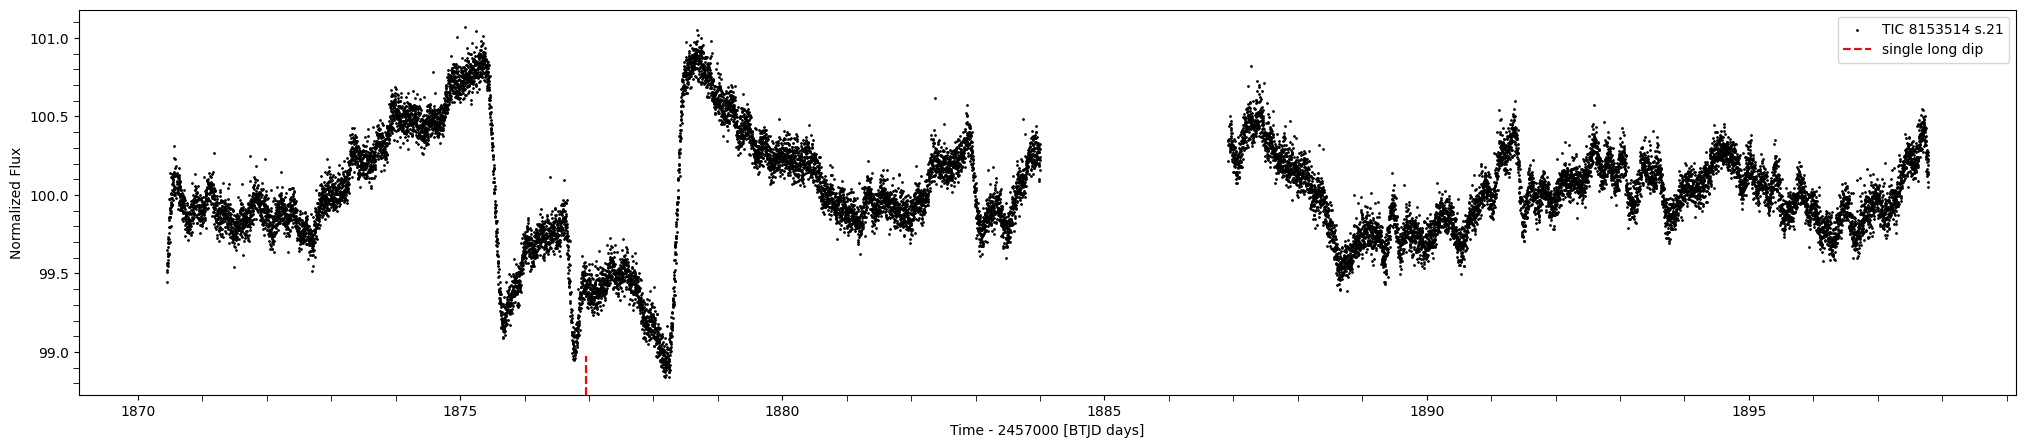

In [48]:
red_marks = dict(linestyle='--', color="red")
blue_marks = dict(linestyle='--', color="blue")
yellow_marks = dict(linestyle='--', color="yellow", ymin=0.1, ymax=0.3, linewidth=2)  # , ymax=0.5
orange_marks = dict(linestyle=':', color="orange", ymin=0.1, ymax=0.3)  # , ymax=0.8
green_marks = dict(linestyle='--', color="green", ymax=0.4)  # , ymax=0.8
purple_marks = dict(linestyle=':', color="purple", ymax=0.4)  # , ymax=0.5

# customize these parameters if needed
lcf_coll_to_use = lcf_coll
tt_specs = transit_specs


axvline_kwargs_specs = [
    red_marks,
    blue_marks
]
skip_no_transit_plot = True

# Now do the marking
axs, tt_lists = [], []
for lc_to_use in lcf_coll_to_use :
    with warnings.catch_warnings():
        # avoid warnings about repeated normalization
        warnings.filterwarnings("ignore", category=lk.LightkurveWarning, message=".*in relative units.*")
#         lc_to_use = tplt._to_lc_with_flux(lc_to_use, "sap_flux")
        lc_to_use = lc_to_use.normalize(unit="percent")  # .remove_outliers(sigma=7)
    ax = plt.figure(figsize=(25, 5)).gca()
    ax1, tt_list = tplt.mark_transit_times(lc_to_use, tt_specs,
                                           axvline_kwargs_specs=axvline_kwargs_specs,
                                           ax=ax,
                                           skip_no_transit_plot=skip_no_transit_plot,
#                                            lc_plot_func_name="plot",
                                          )
    if ax1 is not None:
        axs.append(ax1), tt_lists.append(tt_list)
    else:
        plt.close(ax.figure)

print(tt_specs);
print(tt_lists);
# axs[-1].set_ylim(None, 100.5)

### Plot marked dips, zoomed in

In [46]:
surround_time = 0.5
figsize = (8, 4)

#### Deep eclpises, zoomed in
<a name="marked-dips-deep"></a>

period:  999.0 , t0:  1876.95


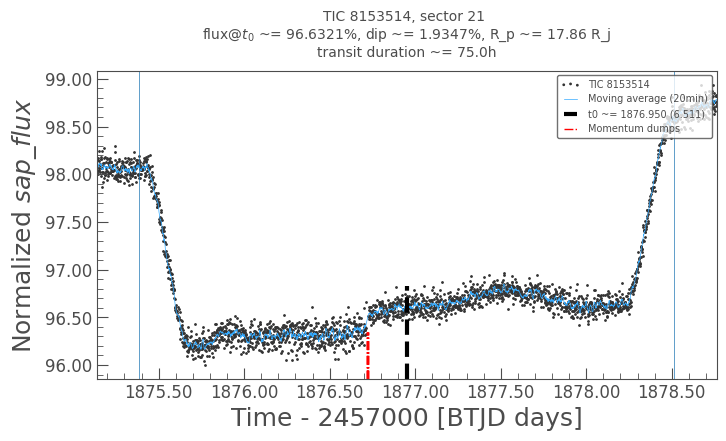

In [50]:
specs_idx = 0  # deep eclipses

t0, period, duration_hr, label = tt_specs[specs_idx]["epoch"], tt_specs[specs_idx]["period"], tt_specs[specs_idx]["duration_hr"], tt_specs[specs_idx]["label"]

def tweak_axs(axs):
#     [ax.set_ylim(axs[-1].get_ylim()) for ax in axs];
#     [ax.set_ylim(99.7, 100.2) for ax in axs];
    return axs;

print("period: ", period, ", t0: ", t0)

axs = []
# check how well the predicted dips fit with observation, using the first and the last sector in the collection
for lc in of_sectors(lcf_coll_to_use[:], lcf_coll_to_use[0].sector, lcf_coll_to_use[-1].sector):
    lc = lke.select_flux(lc, ["sap_flux"])  # ["kspsap_flux", "flux"] #  "sap_flux"
    lc_sap = lc.select_flux("sap_flux") #  use SAP_FLUX to calc transit time to get dips only in SAP_FLUX
    transit_times = lke.get_transit_times_in_lc(lc_sap, t0, period, return_string=False,
#                                                 break_tolerance=1e7,  # also mark data gap, by setting large break_tolerance
                                               )
    for tt in transit_times[:3]:  # limit to 3 per sector for clarity
        with plt.style.context(lk.MPLSTYLE):
            if True:   # for FLUX
                ax = plt.figure(figsize=figsize).gca()
                tplt.plot_transit(lc, ax, tt, duration_hr / 24, surround_time,
                                  moving_avg_window="20min",
                                  title_fontsize=10,
                                  show_r_obj_estimate=True,
                                  legend_kwargs=dict(fontsize=7, loc="upper right")
                                 )
                axs.append(ax)

tweak_axs(axs);

#### Shallow Eclipses, zoomed-in

In [ ]:
specs_idx = 1  # shallow eclipses

t0, period, duration_hr, label = tt_specs[specs_idx]["epoch"], tt_specs[specs_idx]["period"], tt_specs[specs_idx]["duration_hr"], tt_specs[specs_idx]["label"]

def tweak_axs(axs):
#     [ax.set_ylim(axs[-1].get_ylim()) for ax in axs];
#     [ax.set_ylim(99.7, 100.2) for ax in axs];
    return axs;

print("period: ", period, ", t0: ", t0)

axs = []
# check how well the predicted dips fit with observation, using the first and the last sector in the collection
for lc in of_sectors(lcf_coll_to_use[:], lcf_coll_to_use[0].sector, lcf_coll_to_use[-1].sector):
    lc = lke.select_flux(lc, ["flux"])  # ["kspsap_flux", "flux"] #  "sap_flux"
    lc_sap = lc.select_flux("sap_flux") #  use SAP_FLUX to calc transit time to get dips only in SAP_FLUX
    transit_times = lke.get_transit_times_in_lc(lc_sap, t0, period, return_string=False,
#                                                 break_tolerance=1e7,  # also mark data gap, by setting large break_tolerance
                                               )
    for tt in transit_times[:3]:  # limit to 3 per sector for clarity
        with plt.style.context(lk.MPLSTYLE):
            if True:   # for FLUX
                ax = plt.figure(figsize=figsize).gca()
                tplt.plot_transit(lc, ax, tt, duration_hr / 24, surround_time,
                                  moving_avg_window="20min",
                                  title_fontsize=10,
                                  show_r_obj_estimate=True,
                                  legend_kwargs=dict(fontsize=7, loc="upper right")
                                 )
                axs.append(ax)

tweak_axs(axs);

## Lightcurves - folded
<a name="lc-fold">

In [ ]:
# Fold lightcurves

# use all LCs  to see better ensure the period is good
lc = lke.stitch(lcf_coll, corrector_func=tplt.normalize_percent, ignore_incompatible_column_warning=True)

t0 = transit_specs[0]["epoch"]
period = transit_specs[0]["period"]

figsize = (12, 6)
time_bin_size = None  # 10 * u.minute

if time_bin_size is not None:
    lc_b = lke.bin_flux(time_bin_size=time_bin_size)
else:
    lc_b = lc


ax1, lc_f1 = tplt.fold_and_plot(lc_b, period, t0, figsize=figsize)
ax2, lc_f2 = tplt.fold_2x_periods_and_plot(lc_b, period, t0, figsize=figsize)

# used by subsequent cells
# obs_actual_days: defined earlier in section Lightcurves - all
obs_actual_cycles = len(set(lc_f1.cycle))
print(f"# days: {obs_actual_days} ; # cycles: {obs_actual_cycles}")

In [ ]:
to_animate_folded_lc = False

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(10, 5))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_f1
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));
    lc_to_use.meta.get("TARGETID"), len(np.unique(tplt.calc_cycles(lc_to_use)))

## Eclipse Depth from observation
- use folded, detrended, normalized lightcurve
- calculate flux at minimum as the median flux of a 10 minute window of the minimum (possibly many data points due to folding)
- eclipse depth is `1 - flux_at_minimum`, assuming regular (out of eclipse) flux is 100%

In [53]:
# Detrend then fold,
# - eclipses masked out during detrend to preserve them

# use 2 min cadence lightcurves only to make flattening easier (with consistent cadence)
lc = of_lcs(lcf_coll, lambda lc: lc.author == "SPOC").stitch(corrector_func=lambda lc: lc.select_flux("sap_flux").normalize(unit="percent"))

window_length_days = 4 / 24
lc_flattened = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days),
                          mask=lc.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration)
                         ).normalize(unit="percent")

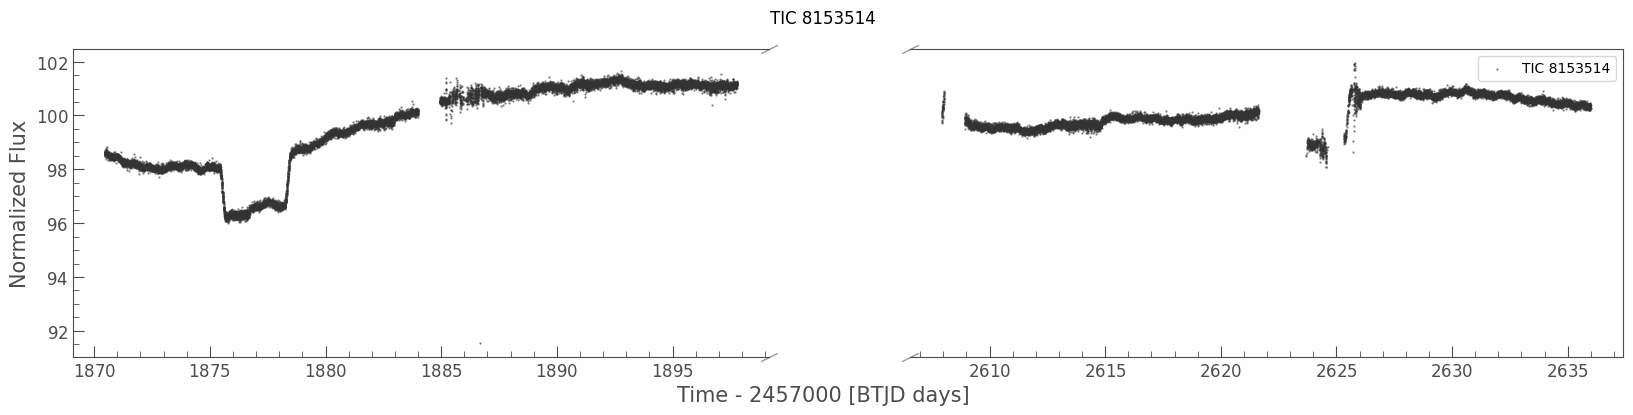

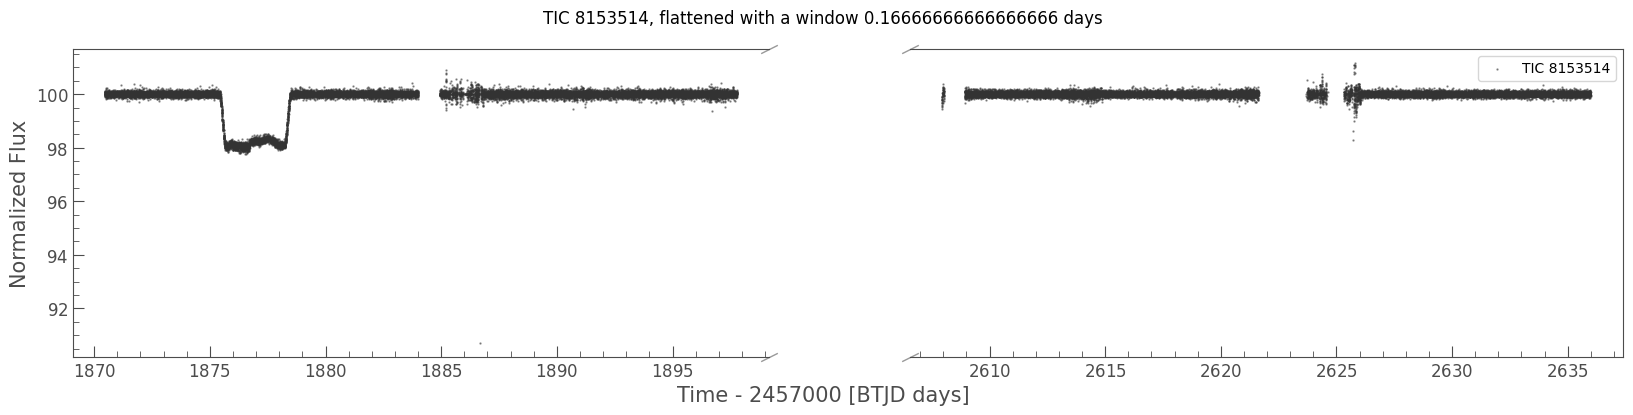

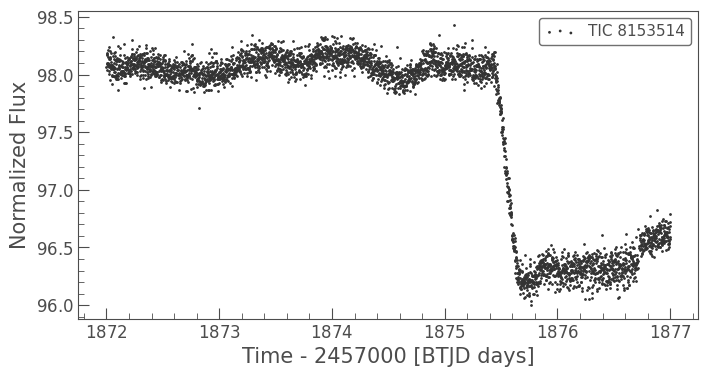

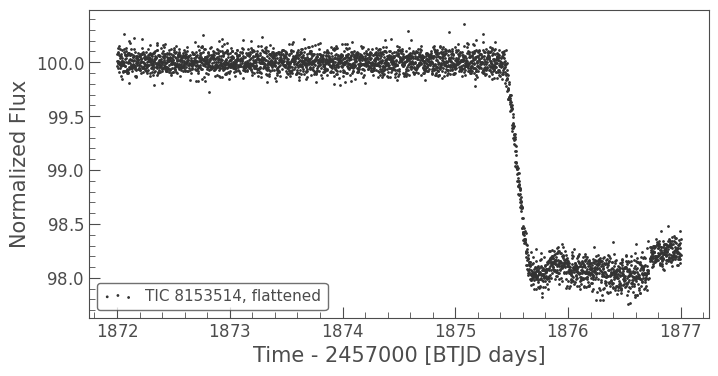

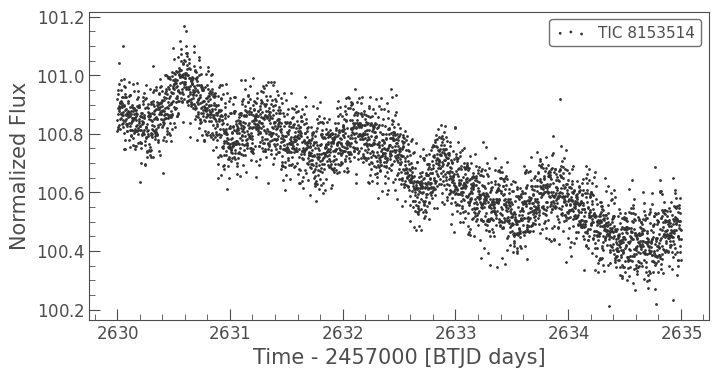

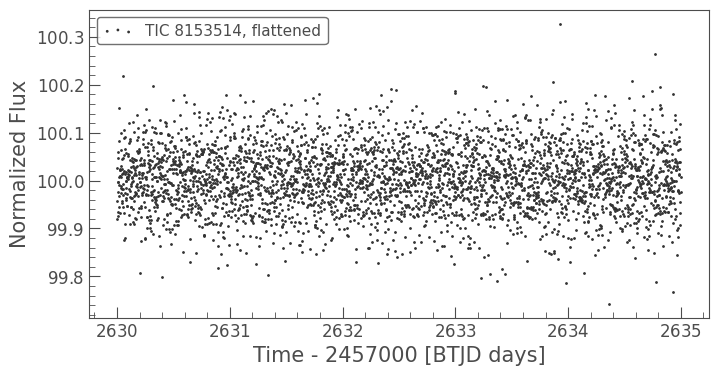

In [54]:
# visualize the detrended lightcurve

figsize = (20, 4)
figsize_z = (8, 4)

axs = tplt.plot_skip_data_gap(lc, figsize=figsize, s=2, alpha=0.5);
axs[0].get_figure().suptitle(f'{lc.label}')

axs = tplt.plot_skip_data_gap(lc_flattened, figsize=figsize, s=2, alpha=0.5);
axs[0].get_figure().suptitle(f'{lc_flattened.label}, flattened with a window {window_length_days} days')

zoom_window = 5

zoom_b, zoom_e = np.ceil(lc_flattened.time.min().value) + 1, np.ceil(lc_flattened.time.min().value) + 1 + zoom_window
lc.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z));
ax = lc_flattened.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z), label=f'{lc.label}, flattened');

zoom_b, zoom_e = np.ceil(lc_flattened.time.max().value) - 1 - zoom_window, np.ceil(lc_flattened.time.max().value) - 1
lc.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z));
ax = lc_flattened.truncate(zoom_b, zoom_e).scatter(ax=tplt.lk_ax(figsize=figsize_z), label=f'{lc.label}, flattened');

### Deep Eclipse depth

Deep eclipse depth: 1.713% ; num. data points: 5


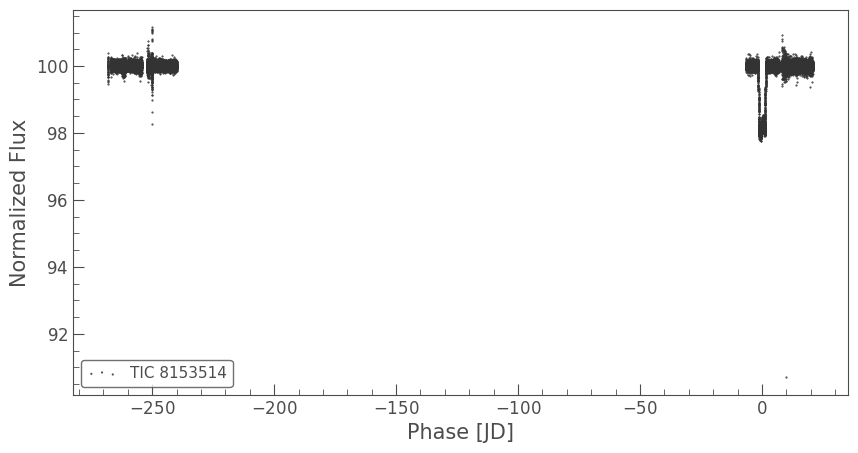

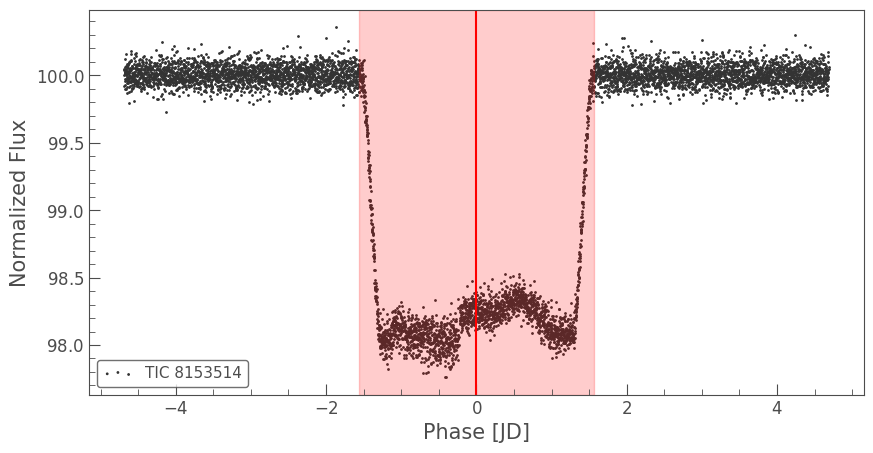

In [55]:
t0 = transit_specs[0]["epoch"]
period = transit_specs[0]["period"]
duration = transit_specs[0]["duration_hr"] / 24

lc_ff_deep = lc_flattened.fold(epoch_time=t0, period=period)

flux_min_deep, flux_min_deep_sample_size = lke.calc_flux_at_minimum(lc_ff_deep)
depth_deep = 1 - flux_min_deep
print(f"Deep eclipse depth: {100*depth_deep:.3f}% ; num. data points: {flux_min_deep_sample_size}")

ax, ax_z = tplt.plot_n_annotate_folded(lc_ff_deep, annotate=False, also_plot_zoom_transit=True, duration=duration)

### Shallow Eclipse Depth

In [ ]:
t0 = transit_specs[1]["epoch"]
period = transit_specs[1]["period"]
duration = transit_specs[1]["duration_hr"] / 24

lc_ff_shallow = lc_flattened.fold(epoch_time=t0, period=period)

flux_min_shallow, flux_min_shallow_sample_size = lke.calc_flux_at_minimum(lc_ff_shallow)
depth_shallow = 1 - flux_min_shallow
print(f"Shallow eclipse depth: {100*depth_shallow:.3f}% ; num. data points: {flux_min_shallow_sample_size}")

ax, ax_z = tplt.plot_n_annotate_folded(lc_ff_shallow, annotate=False, also_plot_zoom_transit=True, duration=duration)

## Identify additional variability
<a name="lc-period">

### Mask out eclipses
to visualize the remaining fluctuations

In [ ]:
# use LCs with all cadences
lc = lke.stitch(lcf_coll, corrector_func=lambda lc: lc.remove_nans().normalize(unit="percent"), ignore_incompatible_column_warning=True)

## use LCs with flux in electron/s only, to calculate FAP
# lc = lke.stitch(lke.select(lcf_coll, lambda lc: lc.author in ["SPOC", "TESS-SPOC"]), corrector_func=lambda lc: lc.remove_nans(), ignore_incompatible_column_warning=True)

t_mask = lc.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration)
lc_masked = lc[~t_mask]

with plt.style.context(lk.MPLSTYLE):
    figsize = (20, 4)
    axs = tplt.plot_skip_data_gap(lc_masked, figsize=figsize, s=2, alpha=0.5);
    axs[0].get_figure().suptitle(f'{lc_masked.label}')

### Lomb Scargle Periodogram

In [ ]:
pg = (
    lc_masked
    .to_periodogram(method="lombscargle"
#                        , minimum_period=.01, maximum_period=25,
#                     ls_method="fastchi2", nterms=3,
                      )
     )
pg.show_properties();

In [ ]:
lke_pg.plot_pg_n_mark_max(pg, max_period_factor=10);

ax = pg.plot(view="period")  # period view, zoom in around peak
ax.set_xlim(pg.period_at_max_power.value / 3 , pg.period_at_max_power.value * 5/3);

ax = pg.plot(view="frequency");  # frequency view
ax.set_xlim(pg.frequency_at_max_power.value / 100 , pg.frequency_at_max_power.value * 5);

# frequency in log scale / microhertz ; useful for, say, solar type oscillator
ax = pg.plot(view="frequency", unit=u.microhertz, scale="log");

if not lc.meta.get("NORMALIZED") and pg.nterms == 1:
    # calc FAP. Somehow it does not work with normalized flux (always return 1.0 for normalized flux)
    pg_fap = pg._LS_object.false_alarm_probability(pg.max_power, method="baluev")  # the FAP is often useless if the lc is normalized
    print("False Alarm Probability:", pg_fap)

In [ ]:
axs = lke_pg.plot_lc_with_model(lc_masked.normalize(), pg);

Animated folded lightcurve 

If the target has additional rotational variability,
- the period holds across sectors
- but the pattern within a period evolves over time. 

In [ ]:
lc_add_var_f = lc_masked.normalize(unit="percent").fold(epoch_time=lc_masked.time.min(), period=pg.period_at_max_power)
ax = lc_add_var_f.scatter(alpha=1.0, s=0.1);
ax.set_title("Folded with Periodogram period, eclipses masked");

# peak to peak as a measure of the amplitude of the additional variability
peak_to_peak_add_var_res = lke.calc_peak_to_peak(lc_add_var_f)
print(f"Peak to peak:")
display(peak_to_peak_add_var_res)

In [ ]:
# animate the folded lightcurve (with periodogram period)
to_animate_folded_lc = True

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(8, 4))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_add_var_f
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));
    lc_to_use.meta.get("TARGETID"), len(np.unique(tplt.calc_cycles(lc_to_use)))

In [ ]:
lc_add_var_f_e = lc_masked.normalize(unit="percent").fold(epoch_time=lc_masked.time.min(), period=transit_specs[0]["period"])
ax = lc_add_var_f_e.scatter(alpha=1.0, s=0.1);
ax.set_title("Folded with Eclipse period, eclipses masked");

In [ ]:
# animate the folded lightcurve (with eclipse period)
to_animate_folded_lc = False

if to_animate_folded_lc:
    ax = tplt.lk_ax(figsize=(8, 4))
    with plt.style.context(lk.MPLSTYLE):  # needed to main lightkurve style in animation
        lc_to_use = lc_add_var_f_e
        tplt.animate_folded_lightcurve(lc_to_use, ax=ax, interval=750, num_frames=240, plot_kwargs=dict(s=9));

## Contamination Check
<a name="contamination"></a>

### Lightcurve - background
<a name="lc-background-sso">

t0= 1876.95


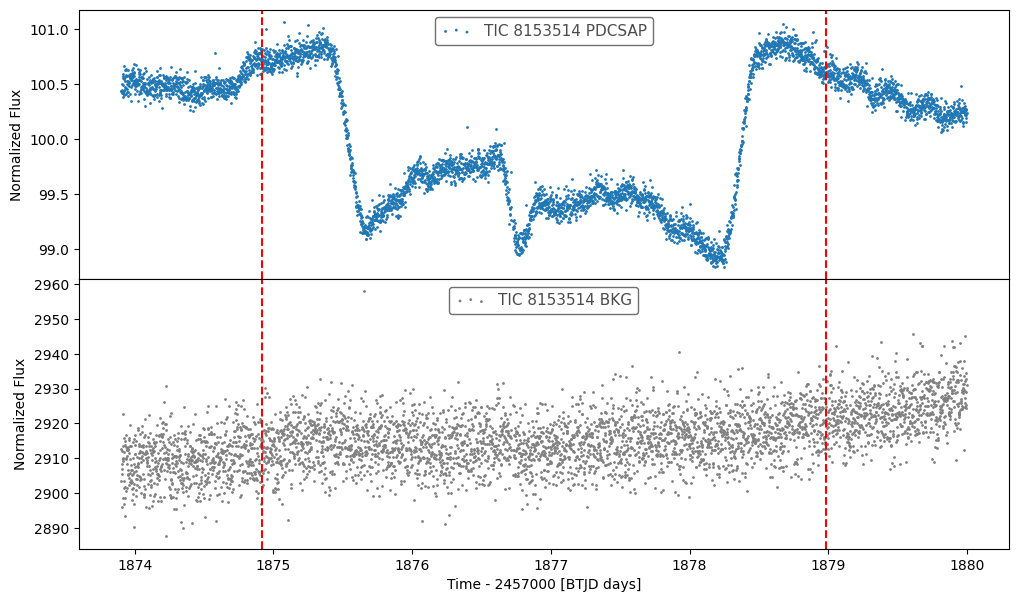

In [18]:
specs_idx, step_idx = 0, 0

lc = of_sector(lcf_coll,  transit_specs[specs_idx]["sector"])
lc = lc.normalize(unit='percent')

# Check the background flux for the duration in question
t0 = transit_specs[specs_idx]["epoch"]
period = transit_specs[specs_idx]["period"]
search_period = transit_specs[specs_idx]["duration_hr"] * 1.3 / 24
plot_period = search_period * 1.5

steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]

search_start, search_end = t0 - search_period /2, t0 + search_period /2
plot_start, plot_end = t0 - plot_period /2, t0 + plot_period /2

plot_binned = False
plot_sap_flux = False

fig, axs = plt.subplots(3 if plot_binned else 2, 1, sharex=True, figsize=(12, 10.5 if plot_binned else 7))
fig.subplots_adjust(hspace=0)

time_mask = (lc.time.value >= plot_start) & (lc.time.value <= plot_end)
if plot_binned:
    lc_b = lke.bin_flux(lc, time_bin_size = 30 * u.minute)  # bin it to speed up SSO search
    lc_b[(lc_b.time.value >= plot_start) & (lc_b.time.value <= plot_end)].scatter(ax=axs[0], label=lc.label + ' binned')

if plot_sap_flux:
    lc_sap[time_mask].scatter(column='sap_flux', ax=axs[-2], c='orange', label=lc.label + 'SAP')
else:
    lc[time_mask].scatter(ax=axs[-2], label=lc.label + ' PDCSAP')

lc_bkg = lke.get_bkg_lightcurve(lc)
lc_bkg[time_mask].scatter(ax=axs[-1], color='gray')

if True and search_start is not None:
    for ax in axs:
        ax.axvline(search_start, linestyle='--', c='r')
        ax.axvline(search_end, linestyle='--', c='r')

print('t0=', t0);

### TPF Download
<a name="tpf_download">

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 21,2020,SPOC,120,8153514,0.0,N/A


TessTargetPixelFile(TICID: 8153514)  , sector 21
     time: 1870.4489248288749 - 1897.7854152989935
cadenceno: 462952 - 482634


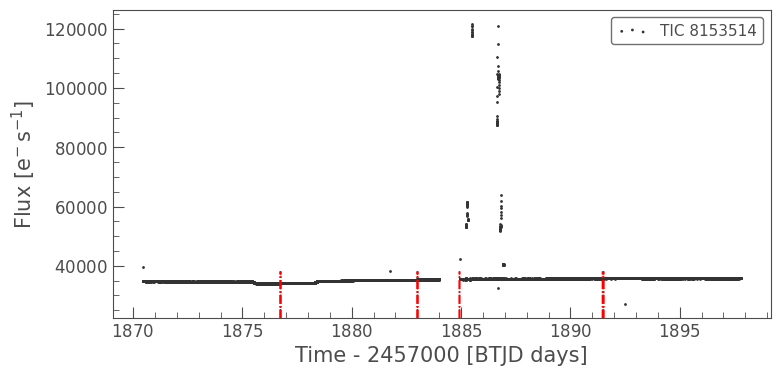

In [19]:
# Google colab user: this cell will fail with SyntaxError in await
# use the next cell instead.

global tpf_task  # need to define it as global, otherwise UnboundLocalError would occur
if tpf_task is None:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir="data")
# else the download has been previoulsy initiated (in "Enter TIC" section, no need to do it),
#      no need to do it again

try:
    tpf_coll, sr_tpf = await tpf_task
    display(sr_tpf)

    if tpf_coll is not None and len(tpf_coll) > 0:
        tpf_original =  tpf_coll[0]
        # data around a momentum dump is often very noisy, exclude them to avoid skewing subsequent plots
        tpf = lket.MomentumDumpsAccessor.exclude_around(tpf_original, window_before=15/60/24, window_after=15/60/24)

        print(tpf, " , sector", tpf.sector)
        print("     time:", tpf.time.min() , "-", tpf.time.max())
        print("cadenceno:", tpf.cadenceno.min() , "-", tpf.cadenceno.max())

        lc = tpf.to_lightcurve().remove_outliers(sigma=8)
        ax = lc.scatter();
        tplt.plot_momentum_dumps(lc, ax)
finally:
    tplt.beep()
    tpf_task = None  # once task result is consumed, reset it so that one can run it again in the next run

### TPF Zoom in, deep eclipse
<a name="tpf_zoom_in">

In [24]:
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))

specs_idx, step_idx = 0, 0
t0 = transit_specs[specs_idx]["epoch"]
duration = transit_specs[specs_idx]["duration_hr"] / 24
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period * steps_to_show[step_idx]
surround_time = 1.0

plot_start, plot_end = t0 - duration / 2 - surround_time / 2,  t0 + duration /2 + surround_time / 2


print('t0 =', t0);

# zoomed in to the time around the dip
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API

# zoom to arbitrary date range
# tpf_trunc = tpf[(tpf.time >= tpf.time.min() + 3) & (tpf.time <= tpf.time.min() + 12)]

if len(tpf_trunc) < 1:
    display(HTML("""<font style="background-color: red;">WARNGING:</font> the truncated TPF is zero length. Sunsequent operations would fail."""))


if (tpf_trunc.time.max() - tpf_trunc.time.min()) > 3 * u.day:
    display(HTML(('<span style="background-color: yellow">Note:</span> The TPF spans over a long time. Consider to zoom in. Duration: '
                  f'{(tpf_trunc.time.max() -tpf_trunc.time.min()).to(u.day)}')))

if 'google.colab' in str(get_ipython()):
    tpf_trunc.to_lightcurve().scatter();
else:
    tpf_trunc.interact(ylim_func=ylim_func,
#                        aperture_mask=tpf.background_mask
#                        transform_func=tplt.normalize_percent,
                       notebook_url=notebook_url,
                      );

t0 = 1876.95


The dip is still there in a smaller aperture. The discontinuity in the middle is due to a momentum dump.

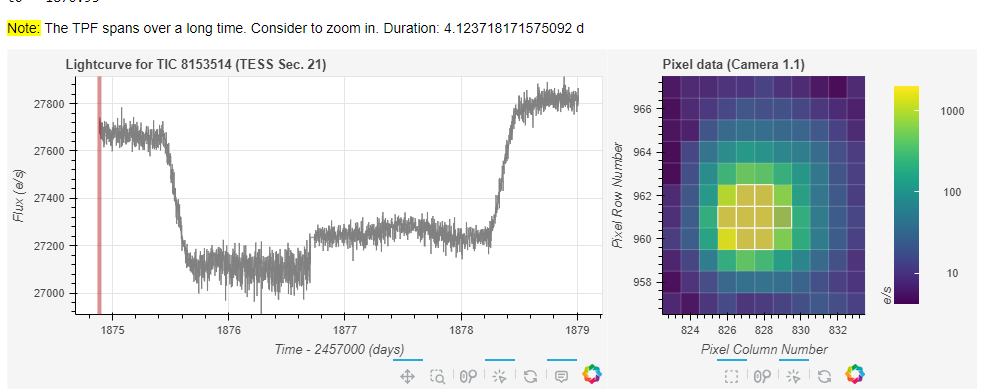


In [21]:
tpf_mag = tpf_trunc.meta.get("TESSMAG")
print('Target magnitude: ', tpf_mag)
magnitude_limit = tpf_mag + 8 if tpf_mag is not None else 18

tplt.show_tpf_orientation(tpf)
tplt.interact_sky(tpf_trunc, aperture_mask="pipeline", magnitude_limit = magnitude_limit, notebook_url=notebook_url,);
tplt.show_nearby_tic_summary_form();

Target magnitude:  9.10029984


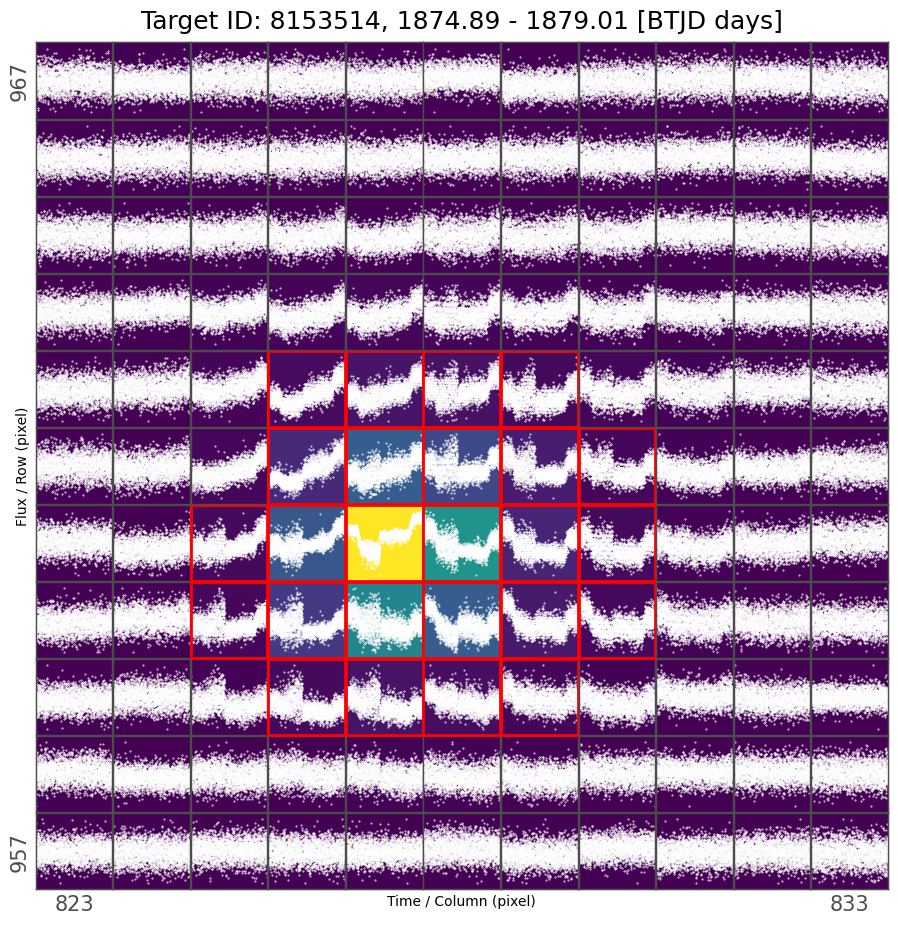

In [22]:
pixel_size_inches, markersize = 1.0, 0.8
fig = plt.figure(figsize=(tpf.flux[0].shape[1] * pixel_size_inches, tpf.flux[0].shape[0] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask=tpf_trunc.pipeline_mask, show_flux=True, markersize=markersize);
tplt.beep();

### TPF Zoom In, shallow eclipses

In [ ]:
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))

specs_idx, step_idx = 1, 0
t0 = transit_specs[specs_idx]["epoch"]
duration = transit_specs[specs_idx]["duration_hr"] / 24
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]
surround_time = 1.0

plot_start, plot_end = t0 - duration / 2 - surround_time / 2,  t0 + duration /2 + surround_time / 2


print('t0 =', t0);

# zommed in to the time around the dip
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API

# zoom to arbitrary date range
# tpf_trunc = tpf[(tpf.time >= tpf.time.min() + 3) & (tpf.time <= tpf.time.min() + 12)]

if len(tpf_trunc) < 1:
    display(HTML("""<font style="background-color: red;">WARNGING:</font> the truncated TPF is zero length. Sunsequent operations would fail."""))


if (tpf_trunc.time.max() - tpf_trunc.time.min()) > 3 * u.day:
    display(HTML(('<span style="background-color: yellow">Note:</span> The TPF spans over a long time. Consider to zoom in. Duration: '
                  f'{(tpf_trunc.time.max() -tpf_trunc.time.min()).to(u.day)}')))

if 'google.colab' in str(get_ipython()):
    tpf_trunc.to_lightcurve().scatter();
else:
    tpf_trunc.interact(ylim_func=ylim_func,
#                        aperture_mask=tpf.background_mask
                       transform_func=tplt.normalize_percent,
                       notebook_url=notebook_url,
                      );

In [ ]:
fig = plt.figure(figsize=(tpf.flux[0].shape[1] * pixel_size_inches, tpf.flux[0].shape[0] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask=tpf_trunc.pipeline_mask, show_flux=True, markersize=markersize);
tplt.beep();

## Reports
<a name="reports"></a>

In [58]:
# Common elements for reports

def get_mag_range_mag_text():
    return f"Mag. range: {flux_range_mag[0]:.2f} - {flux_range_mag[1]:.2f} TESS"


# Fill in for this target
variable_type = "EA:"
remarks = f"Single eclipse over 3 days. Host star K-type giant, likely to be a non singler star, with RUWE: 1.734, sepsi: 49.064, e_RV: 2.52 km/s in Gaia DR3."

# Common helpers, no need to modify
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

### EB Report 
<a name="eb_report"></a>

In [59]:
obs_span_cycles = obs_span / transit_specs[0]["period"]
sectors_all = ",".join([str(s) for s in sr.table["sequence_number"]])
sectors_short_cadence = ",".join([str(s) for s in sr[sr.author == "SPOC"].table["sequence_number"]])  # it could include fast cadence in theory, but not relevant for our usage here.

eb_report = dict(
    tic_id=tic,
    variable_type=variable_type,
    period=transit_specs[0]["period"],
    epoch_deep=transit_specs[0]["epoch"],
    duration_hr_deep=transit_specs[0]["duration_hr"],
    depth_deep=depth_deep,
    epoch_shallow=np.nan,
    duration_hr_shallow=np.nan,
    depth_shallow=np.nan,
    observation_span_days=obs_span,
    observation_span_cycles=np.nan,
    observation_actual_days=obs_actual_days,
    observation_actual_cycles=np.nan,
    sectors=sectors_all,  # used to determine period, epoch, duration
    sectors_short_cadence=sectors_short_cadence,  # used to deteremine depth
    remarks=remarks,
)

with pd.option_context('display.max_colwidth', None):
    display(report_to_df(eb_report))

,Field,Value
0,tic_id,8153514
1,variable_type,EA:
2,period,999.0
3,epoch_deep,1876.95
4,duration_hr_deep,75.0
5,depth_deep,0.017125843364287574
6,epoch_shallow,NaN
7,duration_hr_shallow,NaN
8,depth_shallow,NaN
9,observation_span_days,765.551342


## External Supporting Information
<a name="external_docs"></a>

### TCEs

N/A
